In [87]:
#pip install python-graphblas[default]

Активация библиотек:

In [88]:
import graphblas as gb
gb.init("suitesparse", blocking=False)
from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread
import os
import numpy as np
import random
from graphblas import Matrix, Vector, Scalar

 Используя python-graphblas реализовать функцию **обхода ориентированного графа (MSBFS-Levels) в ширину из нескольких заданных стартовых вершин.** </br>
 +
Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин. </br>
 + Функция возвращает массив пар: стартовая вершина, и массив (levels), где для каждой вершины указано, на каком уровне она достижима из этой стартовой. Стартовая вершина достижима на нулевом уровне, если вершина не достижима, то значение соответствующей ячейки сделайте равной -1.

In [89]:
def MSBFS_Levels(A, s):

    # Проверка графа на ориентированность:
    if A.isequal(A.T) and A.nvals > 0:
        raise Exception ('Граф неориентированный, функция работает только с ориентированными графами')

    # Задаем начальные значения:
    n = A.nrows # Количнство вершин
    m = s.size # Количество стартовых вершин
    result = Matrix(dtypes.INT32, m, n) # Размер возвращаемой матрицы
    f = Matrix(bool, m, n) # Фронт
    succ = Vector(bool, m)
    for i in range(m):
        f[i,s[i]] << True

    # Обход графа в ширину:
    level = 0 # level in BFS traversal
    while True:
      # Заполняем уровни:
      result(mask=f.V) << level
      # Рассчет next frontier:
      f(~result.S, replace=True) << f.mxm(A, semiring.lor_land)

      for i in range(m):
          # Заполняем вектор наличия свободных вершин:
          succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False)

      truee = True
      # Пора останавливать цикл?
      for i in range(m):
          if succ[i]:
          # Проверка до первого true
              truee = False
              break
      if truee:
          break
      level += 1 # Счетчик уровней

    # Вывод результата:
    return {s[i]: np.array([-1 if result[i, j].value is None else result[i, j].value for j in range(n)]) for i in range(m)}

Используя python-graphblas реализовать функцию **обхода ориентированного графа (MSBFS-Parents) в ширину из нескольких заданных стартовых вершин.** </br>
 + Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин. </br>
 + Функция возвращает массив пар: стартовая вершина, и массив (parents), где для каждой вершины графа указано, из какой вершины мы пришли в эту по кратчайшему пути из стартовой вершины. При этом для самой стартовой вершины такое значение взять равное -1, а для недостижимых вершин взять равное -2. При наличии нескольких возможных значений в массивах parents брать наименьшее.

In [90]:
def MSBFS_Parents(A, s):

     # Проверка графа на ориентированность:
    if A.isequal(A.T) and A.nvals > 0:
        raise Exception ('Граф неориентированный, функция работает только с ориентированными графами')
    # Задаем начальные значения:
    N = A.nrows # Количнство вершин
    M = s.size # Количество стартовых вершин
    # Матрица для значений вершин:
    index_ramp = Matrix(dtypes.UINT64, M, N)
    for j in range(N):
        index_ramp[:,j] << j

    parents = Matrix(dtypes.UINT64, M, N)
    wavefront = Matrix(dtypes.UINT64, M, N)

    # Вставим изначальные (стартовые) значения в матрицы parents, wavefront:
    for i in range(M):
        parents[i, s[i]] << s[i]
        wavefront[i, s[i]] << 1

    # Обход графа:
    while wavefront.nvals > 0:
        # Преобразуем сохраненные значения в wavefront в их индекс:
        wavefront << index_ramp.ewise_mult(wavefront, binary.first)
        # Маска списка parents:
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.min_first)
        # Объединение : parents += wavefront
        parents(binary.plus) << wavefront

    # Результат (нет родителя: -2; родитель - стартовая вершина: -1)
    res = {
        s[i]: np.array([
            -2 if parents[i, j].value is None else (-1 if j == s[i] else parents[i, j].value)
            for j in range(N)
        ])
        for i in range(M)
    }
    return res

Добавить тесты для проверки корректности полученных реализаций.

Проверим корректную отработку Exception:

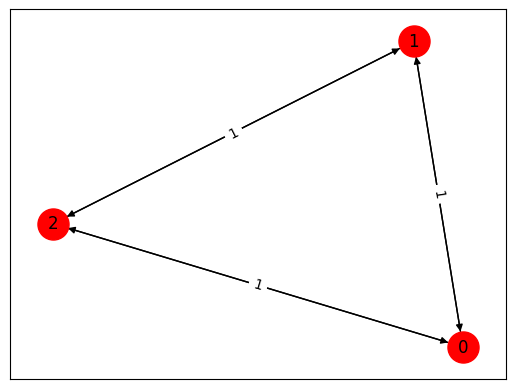

In [91]:
m = np.array([
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]
]) # Неориентированный граф
matrix = gb.Matrix.from_dense(m, missing_value=0)
gb.viz.draw(matrix)

In [92]:
print(MSBFS_Levels(matrix, np.array([0, 1, 2])))

Exception: Граф неориентированный, функция работает только с ориентированными графами

In [93]:
print(MSBFS_Parents(matrix, np.array([0, 1, 2])))

Exception: Граф неориентированный, функция работает только с ориентированными графами

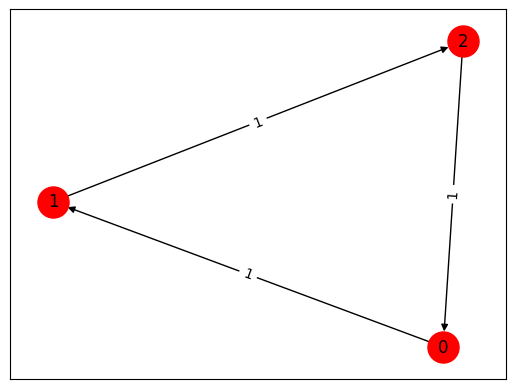

In [94]:
m = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 0]
]) # Ориентированный граф
matrix = gb.Matrix.from_dense(m, missing_value=0)
gb.viz.draw(matrix)

In [95]:
print(MSBFS_Levels(matrix, np.array([0, 1, 2])))

{0: array([0, 1, 2]), 1: array([2, 0, 1]), 2: array([1, 2, 0])}


In [96]:
print(MSBFS_Parents(matrix, np.array([0, 1, 2])))

{0: array([-1,  0,  1]), 1: array([ 2, -1,  1]), 2: array([ 2,  0, -1])}


(+2 балла) Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин.

*Тестирование на графах с SuiteSparse Matrix Collection:*

In [98]:
def GenStartPoint(cnt_vertex, frc_vertex):
    # cnt_vertex - количество вершин, frc_vertex - доля стартовых вершин:
    return np.array(random.sample(range(cnt_vertex), int(frc_vertex / cnt_vertex * 100)))

def GetTests(A, s):
    print('MSBFS_Levels:')
    %timeit MSBFS_Levels(A, s)
    print('MSBFS_Parents:')
    %timeit MSBFS_Parents(A, s)
    print()

In [99]:
frc_vertex = [5, 40, 75, 95] # Доля стартовых вершин
basepath = '/content/data_matrix'
data = os.listdir(basepath)
for file in data:
    path = os.path.join(basepath, file)
    if os.path.isdir(path):
        continue

    M = mmread(f'/content/data_matrix/{file}')
    print(file)
    cnt_vertex = M.shape[0]
    cnt_edge = len(M.to_coo()[0])
    degreee = cnt_edge / (cnt_vertex * (cnt_vertex - 1))
    print(f'Вершины: {cnt_vertex}, ребра: {cnt_edge}, степень разреженности: {degreee:.3f}')

    # Корреляция времени и количества стартовых вершин:
    for i in frc_vertex:
        print(f'Стартовые вершины: {int(i / 100 * M.nrows)}')
        GetTests(M, GenStartPoint(M.nrows, i))
    print('----------------------------')

EVA.mtx
Вершины: 8497, ребра: 6726, степень разреженности: 0.000
Стартовые вершины: 424
MSBFS_Levels:
486 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
MSBFS_Parents:
707 ms ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Стартовые вершины: 3398
MSBFS_Levels:
480 µs ± 9.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
MSBFS_Parents:
606 ms ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Стартовые вершины: 6372
MSBFS_Levels:
544 µs ± 124 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
MSBFS_Parents:
562 ms ± 9.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Стартовые вершины: 8072
MSBFS_Levels:
310 ms ± 9.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS_Parents:
1.01 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

----------------------------
EPA.mtx
Вершины: 4772, ребра: 8965, степень разреженности: 0.000
Стартовые вершины: 238
MSBFS_Levels:
419 µs ± 8.73 µs per loop (mean ± std

*Тестирование на случайных сгенерированных графах:*

In [100]:
def GetGraph(cnt_vertex, cnt_edge):
    positions=[]
    for ind in range(cnt_vertex**2):
        if ind // cnt_vertex != ind % cnt_vertex:
            positions.append(ind)
    gen_ind = random.sample(positions, cnt_edge)

    # Преобразование индексов в координаты (строка, столбец)
    row_ind, col_ind = np.unravel_index(gen_ind, (cnt_vertex, cnt_vertex))

    return gb.Matrix.from_coo(row_ind, col_ind, [1]*len(row_ind), nrows=cnt_vertex, ncols=cnt_vertex)

Зафиксируем значения степени разреженности и числа стартовых вершин и исследуем зависимость от размера графа:

In [102]:
for i in [50, 150, 300]:
    fix_degreee, cnt_start = 0.5, 50
    graph = GetGraph(i, int(fix_degreee * i * (i-1)))
    cnt_vertex = graph.shape[0]
    cnt_edge = len(graph.to_coo()[0])
    degreee = cnt_edge / (cnt_vertex * (cnt_vertex - 1))
    print(f'Вершины: {cnt_vertex}, стартовые вершины: {cnt_start}, степень разреженности: {degreee:.3f}')
    GetTests(graph, gen_vertices(i, cnt_start))
    print('----------------------------')

Вершины: 50, стартовые вершины: 50, степень разреженности: 0.500
MSBFS_Levels:
200 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS_Parents:
113 ms ± 709 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

----------------------------
Вершины: 150, стартовые вершины: 50, степень разреженности: 0.500
MSBFS_Levels:
1.13 s ± 229 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS_Parents:
1.17 s ± 229 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

----------------------------
Вершины: 300, стартовые вершины: 50, степень разреженности: 0.500
MSBFS_Levels:
5.44 s ± 2.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS_Parents:
4.53 s ± 533 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

----------------------------


При увеличении количества вершин время работы алгоритмов MSBFS-Levels и MSBFS-Parents тоже увеличивается, так как происходит увеличение количества столбцов в матрицах, что оказывает влияние на время выполнения операции матричного умножения.

Зафиксируем размер графа и количество стартовых вершин и исследуем зависимость от степени разряженности:

In [103]:
for i in [0.2, 0.4, 0.6]:
    fix_cnt_vertex, cnt_start = 200, 20
    graph = GetGraph(fix_cnt_vertex, int(i * fix_cnt_vertex * (fix_cnt_vertex-1)))
    cnt_vertex = graph.shape[0]
    cnt_edge = len(graph.to_coo()[0])
    degreee = cnt_edge / (cnt_vertex * (cnt_vertex - 1))
    print(f'Количество вершин: {cnt_vertex}, степень разреженности: {degreee:.2f}, доля стартовых вершин: {cnt_start}%')
    GetTests(graph, gen_vertices(fix_cnt_vertex, cnt_start))
    print('----------------------------')

Количество вершин: 200, степень разреженности: 0.20, доля стартовых вершин: 20%
MSBFS_Levels:
709 ms ± 9.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS_Parents:
852 ms ± 200 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

----------------------------
Количество вершин: 200, степень разреженности: 0.40, доля стартовых вершин: 20%
MSBFS_Levels:
698 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS_Parents:
808 ms ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

----------------------------
Количество вершин: 200, степень разреженности: 0.60, доля стартовых вершин: 20%
MSBFS_Levels:
702 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS_Parents:
783 ms ± 149 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

----------------------------


При увеличении степени разреженности резкого увеличения времени выполнения алгоритма нет. Также можно отметить, что при степени разреженности 0.4 MSBFS-Levels показал себя лучше всего, когда MSBFS-Parents при 0.6.

Зафиксируем размер графа и степень разряженности и исследуем зависимость от количества стартовых вершин:

In [104]:
for i in [20, 40, 60]:
    cnt_vertex, fix_raref_deg = 20, 0.5
    graph = GetGraph(cnt_vertex, int(fix_raref_deg * cnt_vertex * (cnt_vertex-1)))
    cnt_vertexx = graph.shape[0]
    cnt_edge = len(graph.to_coo()[0])
    degreee = cnt_edge / (cnt_vertexx * (cnt_vertexx - 1))
    print(f'Количество вершин: {cnt_vertex}, степень разреженности: {degreee:.2f}, доля стартовых вершин: {i}%')
    GetTests(graph, gen_vertices(cnt_vertex, i))
    print('----------------------------')

Количество вершин: 20, степень разреженности: 0.50, доля стартовых вершин: 20%
MSBFS_Levels:
9.42 ms ± 85.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
MSBFS_Parents:
10.9 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

----------------------------
Количество вершин: 20, степень разреженности: 0.50, доля стартовых вершин: 40%
MSBFS_Levels:
19.5 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
MSBFS_Parents:
18.2 ms ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

----------------------------
Количество вершин: 20, степень разреженности: 0.50, доля стартовых вершин: 60%
MSBFS_Levels:
28.3 ms ± 767 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
MSBFS_Parents:
31.4 ms ± 7.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

----------------------------


С ростом стартовых вершинпроисходит увеличение времени работы обоих алгоритмов.

(+3 балла) Добавить реализации описанных алгоритмов с использованием других полуколец (any.pair для levels и any.first для parents). Добавить тесты для проверки корректности. Провести экспериментальное исследование со сравнением этих реализаций с первоначальными на различных графах.

In [105]:
def MSBFS_Parents_any_first(A, s):

     # Проверка графа на ориентированность:
    if A.isequal(A.T) and A.nvals > 0:
        raise Exception ('Граф неориентированный, функция работает только с ориентированными графами')
    # Задаем начальные значения:
    N = A.nrows # Количнство вершин
    M = s.size # Количество стартовых вершин
    # Матрица для значений вершин:
    index_ramp = Matrix(dtypes.UINT64, M, N)
    for j in range(N):
        index_ramp[:,j] << j

    parents = Matrix(dtypes.UINT64, M, N)
    wavefront = Matrix(dtypes.UINT64, M, N)

    # Вставим изначальные (стартовые) значения в матрицы parents, wavefront:
    for i in range(M):
        parents[i, s[i]] << s[i]
        wavefront[i, s[i]] << 1

    # Обход графа:
    while wavefront.nvals > 0:
        # Преобразуем сохраненные значения в wavefront в их индекс:
        wavefront << index_ramp.ewise_mult(wavefront, binary.first)
        # Маска списка parents:
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.any_first)
        # Объединение : parents += wavefront
        parents(binary.plus) << wavefront

    # Результат (нет родителя: -2; родитель - стартовая вершина: -1)
    res = {
        s[i]: np.array([
            -2 if parents[i, j].value is None else (-1 if j == s[i] else parents[i, j].value)
            for j in range(N)
        ])
        for i in range(M)
    }
    return res

In [106]:
def MSBFS_Levels_any_pair(A, s):

    # Проверка графа на ориентированность:
    if A.isequal(A.T) and A.nvals > 0:
        raise Exception ('Граф неориентированный, функция работает только с ориентированными графами')

    # Задаем начальные значения:
    n = A.nrows # Количнство вершин
    m = s.size # Количество стартовых вершин
    result = Matrix(dtypes.INT32, m, n) # Размер возвращаемой матрицы
    f = Matrix(bool, m, n) # Фронт
    succ = Vector(bool, m)
    for i in range(m):
        f[i,s[i]] << True

    # Обход графа в ширину:
    level = 0 # level in BFS traversal
    while True:
      # Заполняем уровни:
      result(mask=f.V) << level
      # Рассчет next frontier:
      f(~result.S, replace=True) << f.mxm(A, semiring.any_pair)

      for i in range(m):
          # Заполняем вектор наличия свободных вершин:
          succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False)

      truee = True
      # Пора останавливать цикл?
      for i in range(m):
          if succ[i]:
          # Проверка до первого true
              truee = False
              break
      if truee:
          break
      level += 1 # Счетчик уровней

    # Вывод результата:
    return {s[i]: np.array([-1 if result[i, j].value is None else result[i, j].value for j in range(n)]) for i in range(m)}

In [107]:
def GetTests_dop(A, s):
    print('MSBFS_Parents_any_first:')
    %timeit MSBFS_Parents_any_first(A, s)
    print('MSBFS_Levels_any_pair:')
    %timeit MSBFS_Levels_any_pair(A, s)
    print()

Зафиксируем значения степени разреженности и числа стартовых вершин и исследуем зависимость от размера графа:

In [108]:
for i in [50, 150, 300]:
    fix_degreee, cnt_start = 0.5, 50
    graph = GetGraph(i, int(fix_degreee * i * (i-1)))
    cnt_vertex = graph.shape[0]
    cnt_edge = len(graph.to_coo()[0])
    degreee = cnt_edge / (cnt_vertex * (cnt_vertex - 1))
    print(f'Вершины: {cnt_vertex}, стартовые вершины: {cnt_start}, степень разреженности: {degreee:.3f}')
    GetTests_dop(graph, gen_vertices(i, cnt_start))
    print('----------------------------')

Вершины: 50, стартовые вершины: 50, степень разреженности: 0.500
MSBFS_Parents_any_first:
133 ms ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
MSBFS_Levels_any_pair:
136 ms ± 26.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

----------------------------
Вершины: 150, стартовые вершины: 50, степень разреженности: 0.500
MSBFS_Parents_any_first:
1.59 s ± 833 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS_Levels_any_pair:
1.21 s ± 339 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

----------------------------
Вершины: 300, стартовые вершины: 50, степень разреженности: 0.500
MSBFS_Parents_any_first:
5.94 s ± 1.12 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS_Levels_any_pair:
4.27 s ± 556 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

----------------------------


Зафиксируем размер графа и количество стартовых вершин и исследуем зависимость от степени разряженности:

In [109]:
for i in [0.2, 0.4, 0.6]:
    fix_cnt_vertex, cnt_start = 200, 20
    graph = GetGraph(fix_cnt_vertex, int(i * fix_cnt_vertex * (fix_cnt_vertex-1)))
    cnt_vertex = graph.shape[0]
    cnt_edge = len(graph.to_coo()[0])
    degreee = cnt_edge / (cnt_vertex * (cnt_vertex - 1))
    print(f'Количество вершин: {cnt_vertex}, степень разреженности: {degreee:.2f}, доля стартовых вершин: {cnt_start}%')
    GetTests_dop(graph, gen_vertices(fix_cnt_vertex, cnt_start))
    print('----------------------------')

Количество вершин: 200, степень разреженности: 0.20, доля стартовых вершин: 20%
MSBFS_Parents_any_first:
793 ms ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS_Levels_any_pair:
721 ms ± 57.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

----------------------------
Количество вершин: 200, степень разреженности: 0.40, доля стартовых вершин: 20%
MSBFS_Parents_any_first:
745 ms ± 90.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS_Levels_any_pair:
777 ms ± 181 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

----------------------------
Количество вершин: 200, степень разреженности: 0.60, доля стартовых вершин: 20%
MSBFS_Parents_any_first:
710 ms ± 7.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSBFS_Levels_any_pair:
813 ms ± 189 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

----------------------------


Зафиксируем размер графа и степень разряженности и исследуем зависимость от количества стартовых вершин:

In [110]:
for i in [20, 40, 60]:
    cnt_vertex, fix_raref_deg = 20, 0.5
    graph = GetGraph(cnt_vertex, int(fix_raref_deg * cnt_vertex * (cnt_vertex-1)))
    cnt_vertexx = graph.shape[0]
    cnt_edge = len(graph.to_coo()[0])
    degreee = cnt_edge / (cnt_vertexx * (cnt_vertexx - 1))
    print(f'Количество вершин: {cnt_vertex}, степень разреженности: {degreee:.2f}, доля стартовых вершин: {i}%')
    GetTests_dop(graph, gen_vertices(cnt_vertex, i))
    print('----------------------------')

Количество вершин: 20, степень разреженности: 0.50, доля стартовых вершин: 20%
MSBFS_Parents_any_first:
10.5 ms ± 1.98 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
MSBFS_Levels_any_pair:
9.86 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

----------------------------
Количество вершин: 20, степень разреженности: 0.50, доля стартовых вершин: 40%
MSBFS_Parents_any_first:
18.6 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
MSBFS_Levels_any_pair:
20.3 ms ± 3.61 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

----------------------------
Количество вершин: 20, степень разреженности: 0.50, доля стартовых вершин: 60%
MSBFS_Parents_any_first:
23.5 ms ± 554 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
MSBFS_Levels_any_pair:
28.2 ms ± 904 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

----------------------------


После сравнения алгоритмов с различными вариациями полуколец можно сделать вывод о том, что время отработки алгоритмов практически не изменилось. </br>
В случае проведения эксперментов с использованием крайних значений рассматриваемых параметров алгоритм MSBFS- Levels в начальном полукольце показал лучшее время.